Refer to https://blog.csdn.net/u012285175/article/details/84838998

### 2.1 Image Format, Thresholding, Conversion

To convert a RGB image into gray-scale image, one converts the color values to a gray value L by adding
the three components according to a specific ratio, for instance:

**L = 0.2989 · R + 0.5870 · G + 0.1140 · B**

In [1]:
from numpy import arange, ones, histogram
from skimage.io import imread
from skimage.color import rgb2gray
from scipy.signal import convolve2d

Irgb = imread('img/KlausIohannis.jpg') # loading the image
Igry = rgb2gray(Irgb) # convert to gray-scale
# 这里 Igry 的元素是 float型，范围 [0, 1.0]
IrgbCen = Irgb[100:500,250:570,:] # zoom into center
Igreen = Irgb[:,:,2] # green channel only
BWflw = Igry>0.3 # thresholding (black-white image)
Iblur = convolve2d(Igry,ones((25,25))) # blurring the image

Text(0.5, 1.0, 'Blurred Image')

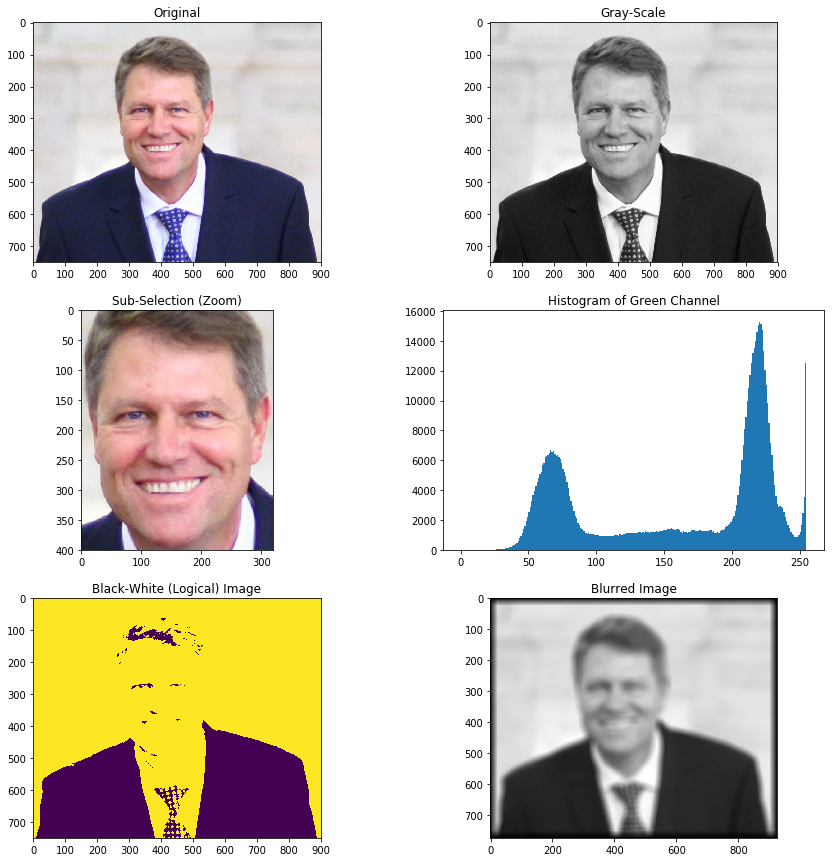

In [2]:
%matplotlib inline
from matplotlib.pyplot import figure, subplot, imshow, plot, hist, title, cm

figure(figsize=(15,15)); (nr,nc) = (3,2)
subplot(nr,nc,1); imshow(Irgb); title('Original')
subplot(nr,nc,2); imshow(Igry, cmap=cm.gray); title('Gray-Scale')
subplot(nr,nc,3); imshow(IrgbCen); title('Sub-Selection (Zoom)')
subplot(nr,nc,4); hist(Igreen.flatten(),bins=arange(256)); title('Histogram of Green Channel')
subplot(nr,nc,5); imshow(BWflw); title('Black-White (Logical) Image')
subplot(nr,nc,6); imshow(Iblur, cmap=cm.gray); title('Blurred Image')

### 2.2 Image Enhancement

If an image shows low contrast, then it can be manipulated to show higher contrast by shifting its pixel
values according to some distribution. The manipulations are typically based on the image histogram (Fig.
2 center right). In an image with low contrast, the histogram shows a peak at either side, see Fig. 4 left
side. During the equalization process, that histogram peak is moved more toward the center (right side in
Figure), based on an input histogram distribution. The result is often visually appealing and is also used
occasionally when training recognition systems.

In Python those functions are within module **skimage.exposure**. For instance with **equalize_hist** the
histogram equalization is carried, whereby there the default input histogram consists of 256 bins.

即：低对比度，可以使用直方图均衡，视觉效果一般会改善，偶尔也用在识别系统中。

对于椒盐噪声，可以使用中值滤波。

A type of ‘noise’ that is also called saltand-pepper noise, because those stand-out pixels appear like grains of salt (bright) or pepper (dark) on an image.

In Python the function **medfilt2d** can be found in module **scipy.signal**.

### 2.3 Face Part Detection

- 在水平和垂直方向上积分
- 分别低通滤波，过滤高频极值
- 极值检测

这种类型的面部局部定位稍微简单，但其时间复杂度较低，这就是为什么这种方法经常被用作更复杂的面部特征跟踪系统的第一阶段的原因。 许多应用的计算机视觉系统由级联的子系统组成，这些子系统逐渐地以越来越高的精度执行任务。

In [3]:
from numpy         import asarray, diff, nonzero, shape, sign, sum
from skimage.io    import imread
from skimage.color import rgb2gray
from scipy.signal  import convolve, get_window, argrelmax, argrelmin

#%% ----    Load Image -----
Irgb  = imread('img/KlausIohannisCrop.jpg')  # image is color [m n 3]             
Ig    = rgb2gray(Irgb)      # turn into graylevel image
Ig    = Ig[34:-36,34:-36]   # crop borders a bit more
(h,w) = shape(Ig)           # image height and width

In [4]:
#%% =====   Raw Profiles   ======
Pver    = sum(Ig,axis=0)  # vertical intensity profile
Phor    = sum(Ig,axis=1)  # horizontal
# 对于 sum()，axis = None，全部加起来。axis = 0，累加行，axis = 1，累加列

#%% =====   Smoothen Profiles    =======
sgm     = 10
nPf     = round(w*0.10);                    # #points: fraction of image width
LowFlt  = get_window(('gaussian', sgm),nPf) # generate a Gaussian
LowFlt  = LowFlt / sum(LowFlt)              # normalize the filter
Pverf   = convolve(Pver, LowFlt, 'same')    # filter vertical profile
Phorf   = convolve(Phor, LowFlt, 'same')    # filter horizontal profile
 
#%% =====   Detect Extrema     =======
LocMaxVer   = argrelmax(Pverf)              # peaks
LocMinVer   = argrelmin(Pverf)              # troughs (sinks)
LocMaxHor   = argrelmax(Phorf)              # peaks
LocMinHor   = argrelmin(Phorf)              # troughs (sinks)

Text(0.5, 1.0, 'Horizontal Profile')

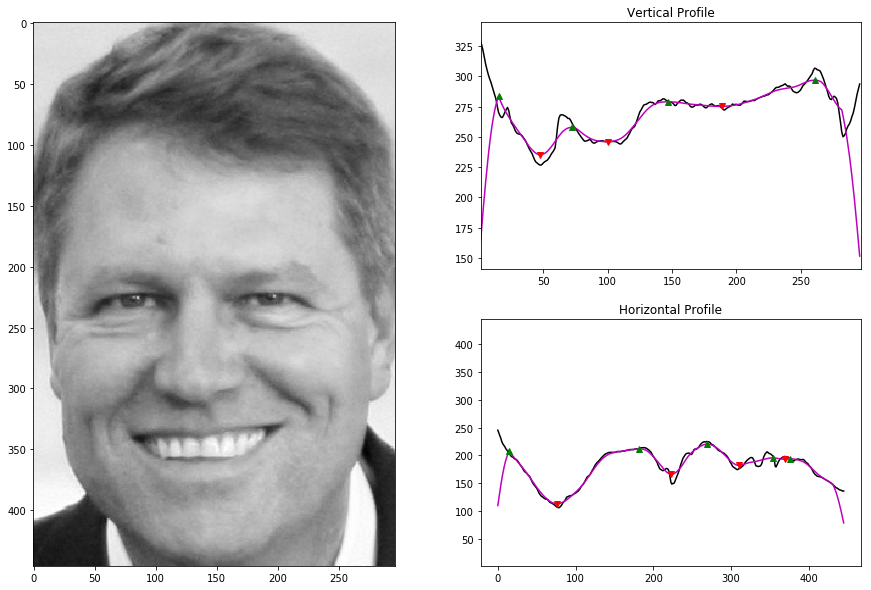

In [5]:
#%% ---- Plotting
%matplotlib inline
from matplotlib.pyplot import figure, subplot, imshow, plot, title, xlim, ylim, cm

figure(figsize=(15,10)) # w=15, h=10，单位英寸
subplot(1,2,1) # 一行二列，第1幅图
imshow(Ig, cmap=cm.gray)

subplot(2,2,2) # 二行二列，第2幅图
plot(Pver,'k')
plot(Pverf,'m')
plot(LocMaxVer[0],Pverf[LocMaxVer],'g^')
plot(LocMinVer[0],Pverf[LocMinVer],'rv')
xlim(1,w)
title('Vertical Profile')

subplot(2,2,4)
plot(Phor,'k')
plot(Phorf,'m')
plot(LocMaxHor[0],Phorf[LocMaxHor],'g^')
plot(LocMinHor[0],Phorf[LocMinHor],'rv')
ylim(1,h)
title('Horizontal Profile')